In [1]:
#install the required libraries
!pip install tensorflow -qqq
!pip install keras -qqq
!pip install yfinance -qqq
!pip install ta -qqq
!pip install pandas -qqq
!pip install numpy -qqq
!pip install matplotlib -qqq
!pip install scikit-learn -qqq
!pip install mplfinance -qqq

In [2]:
# Importing necessary libraries after install
import tensorflow as tf
import yfinance as yf
import numpy as np
import datetime 
import pandas as pd
import ta
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, AdditiveAttention, Permute, Reshape, Multiply
from keras.callbacks import EarlyStopping

# Global constants
WINDOW_SIZE = 100
FEATURE_COUNT = 5


In [3]:
#User selects a ticker and fetches data for multiple stocks

print("Available tickers: MSFT, TSLA, AAL")

# Allow up to 3 attempts to enter a valid ticker
attempts = 3
selected_ticker = None

for attempt in range(attempts):
    selected_ticker = input("Please enter the ticker you want to analyze: ").upper()
    
    # Validate the input
    if selected_ticker in ['MSFT', 'TSLA', 'AAL']:
        print(f"You selected: {selected_ticker}")
        break
    else:
        print(f"Invalid ticker. You have {attempts - attempt - 1} attempts remaining.")

# If all attempts fail, display a message and exit
if selected_ticker not in ['MSFT', 'TSLA', 'AAL']:
    print("Please take your time typing the ticker, restart the program now.")
    raise SystemExit

# Fetch data for multiple stocks
tickers = ['MSFT', 'TSLA', 'AAL']
stock_data = {}
today = datetime.datetime.today().strftime('%Y-%m-%d')

for ticker in tickers:
    stock_data[ticker] = yf.download(ticker, start='2020-01-01', end=today)


    
# Display the first few rows of the selected ticker's dataframe
print(f"Displaying data for {selected_ticker}:")
print(stock_data[selected_ticker].head())


Available tickers: MSFT, TSLA, AAL
You selected: AAL
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Displaying data for AAL:
Price           Close       High        Low       Open    Volume
Ticker            AAL        AAL        AAL        AAL       AAL
Date                                                            
2020-01-02  28.982893  29.192119  28.544513  28.873297   6451100
2020-01-03  27.548195  28.185840  27.239337  28.165913  14008900
2020-01-06  27.219410  27.388784  26.980294  27.089889   6105800
2020-01-07  27.119778  27.578085  26.960367  27.458526   6105900
2020-01-08  27.737495  27.986575  26.970330  27.000220  10496800


In [4]:
# Fetch extended stock data for the selected ticker
today = datetime.datetime.today().strftime('%Y-%m-%d')
data = yf.download(selected_ticker, start='2020-01-01', end=today)
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# Technical Indicators
close_prices = data['Close'].squeeze()
data['RSI'] = ta.momentum.RSIIndicator(close=close_prices).rsi()
data['MACD'] = ta.trend.MACD(close=close_prices).macd()
bollinger = ta.volatility.BollingerBands(close=close_prices)
data['Bollinger_High'] = bollinger.bollinger_hband()
data['Bollinger_Low'] = bollinger.bollinger_lband()

# Handle NaNs (due to indicators)
data.dropna(inplace=True)

# Display the first few rows with indicators
print(data.head())

[*********************100%***********************]  1 of 1 completed


Price            Open       High        Low      Close    Volume        RSI  \
Ticker            AAL        AAL        AAL        AAL       AAL              
Date                                                                          
2020-02-07  28.059999  28.549999  27.780001  28.379999   6231800  53.456588   
2020-02-10  28.190001  28.809999  27.980000  28.790001  15134300  55.923375   
2020-02-11  29.059999  29.940001  28.969999  29.840000   8977700  61.544462   
2020-02-12  30.000000  30.780001  29.990000  30.469999   9315400  64.472098   
2020-02-13  30.030001  30.400000  29.730000  30.090000   9119400  61.434049   

Price           MACD Bollinger_High Bollinger_Low  
Ticker                                             
Date                                               
2020-02-07 -0.000724      29.103741     26.049645  
2020-02-10  0.073287      29.260246     26.050199  
2020-02-11  0.214199      29.637187     25.928343  
2020-02-12  0.372415      30.117847     25.751820  
202

In [5]:
# Small data cleaning
# Checking for missing values
missing_values = stock_data[ticker].isnull().sum().sum()  # Total number of missing values in the DataFrame

if missing_values > 0:
    print(f"Missing values detected: {missing_values}. Handling missing values...")
    
    # Filling missing values, if any
    stock_data[ticker].fillna(method='ffill', inplace=True)  # Forward fill
    stock_data[ticker].fillna(method='bfill', inplace=True)  # Backward fill

    # Recalculate technical indicators after filling missing values
    close_prices = stock_data[ticker]['Close'].squeeze()

    # Calculate RSI
    stock_data[ticker]['RSI'] = ta.momentum.RSIIndicator(close=close_prices).rsi()

    # Calculate MACD
    stock_data[ticker]['MACD'] = ta.trend.MACD(close=close_prices).macd()

    # Calculate Bollinger Bands
    bollinger = ta.volatility.BollingerBands(close=close_prices)
    stock_data[ticker]['Bollinger_High'] = bollinger.bollinger_hband()
    stock_data[ticker]['Bollinger_Low'] = bollinger.bollinger_lband()

    # Drop any remaining NaN values caused by indicator calculations
    stock_data[ticker].dropna(inplace=True)

    print("Missing values handled and technical indicators recalculated.")
else:
    print("No missing values detected. Skipping missing value handling.")

# Display the first few rows with indicators placed
print("Data after processing:")
print(stock_data[ticker].head())

No missing values detected. Skipping missing value handling.
Data after processing:
Price           Close       High        Low       Open    Volume
Ticker            AAL        AAL        AAL        AAL       AAL
Date                                                            
2020-01-02  28.982893  29.192119  28.544513  28.873297   6451100
2020-01-03  27.548195  28.185840  27.239337  28.165913  14008900
2020-01-06  27.219410  27.388784  26.980294  27.089889   6105800
2020-01-07  27.119778  27.578085  26.960367  27.458526   6105900
2020-01-08  27.737495  27.986575  26.970330  27.000220  10496800


In [6]:
# Ensure the required columns exist
required_columns = ['Close', 'RSI', 'MACD', 'Bollinger_High', 'Bollinger_Low']
for col in required_columns:
    if col not in data.columns:
        raise KeyError(f"'{col}' column not found in the data. Please check the data source.")

# Drop NaNs before fitting
data.dropna(inplace=True)

# Fit the scaler once on all required features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[required_columns])
print(f"Data for {selected_ticker} has been scaled with {len(required_columns)} features.")

# Save the last 60 rows for future prediction
latest_data = data[required_columns].values[-60:]
scaled_latest_data = scaler.transform(latest_data)
X_latest = np.reshape(scaled_latest_data, (1, 60, len(required_columns)))  # Shape: (1, 60, 5)


Data for AAL has been scaled with 5 features.


In [7]:
# Preparing the data for LSTM
X, y = [], []

# Use scaled data for the selected ticker
for i in range(WINDOW_SIZE, len(scaled_data)):
    X.append(scaled_data[i - WINDOW_SIZE:i])
    y.append(scaled_data[i, 0])  # Predict Close

X, y = np.array(X), np.array(y)
print(f"Prepared LSTM data for {selected_ticker} stock.")
print(f"X shape: {X.shape}, y shape: {y.shape}")


Prepared LSTM data for AAL stock.
X shape: (1206, 100, 5), y shape: (1206,)


In [8]:
# Splitting the data into training and testing sets
# 80% for training and 20% for testing
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Data split completed for {selected_ticker}.")
print(f"Train set size: {len(X_train)}, Test set size: {len(X_test)}")


Data split completed for AAL.
Train set size: 964, Test set size: 242


In [9]:
# Reshaping the training data for LSTM
X_train = np.array(X_train)
y_train = np.array(y_train)

# Ensure the shape is (num_samples, timesteps, num_features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
print(f"Reshaped X_train: {X_train.shape}")

Reshaped X_train: (964, 100, 5)


In [10]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(WINDOW_SIZE, FEATURE_COUNT)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
print(f"LSTM model built for {selected_ticker}.")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM model built for AAL.


In [11]:
# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')

# Define the input explicitly
input_layer = tf.keras.layers.Input(shape=(WINDOW_SIZE, FEATURE_COUNT))  # Use global constants for timesteps and features
x = LSTM(units=50, return_sequences=True)(input_layer)
x = LSTM(units=50, return_sequences=True)(x)

# Permute and reshape for compatibility
x = Permute((2, 1))(x)
x = Reshape((-1, WINDOW_SIZE))(x)  # Use global constant for timesteps

# Apply attention
attention_result = attention([x, x])
x = Multiply()([x, attention_result])

# Return to original shape
x = Permute((2, 1))(x)
x = Reshape((-1, 50))(x)

# Adding a Flatten layer before the final Dense layer
x = tf.keras.layers.Flatten()(x)
output_layer = Dense(1)(x)

# Create the model
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

print(f"Self-attention LSTM model built for {selected_ticker}.")

Self-attention LSTM model built for AAL.


In [12]:
# Adding Dropout and Batch Normalization
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

print(f"Dropout and Batch Normalization layers added for {selected_ticker}.")

Dropout and Batch Normalization layers added for AAL.


In [13]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 100, 50)   │     11,200 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 100, 50)   │     20,200 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 50, 100)   │          0 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 100)   │          0 │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight    │ (None, 50, 100)   │        100 │ reshape[0][0],    │
│ (AdditiveAttention) │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 50, 100)   │          0 │ reshape[0][0],    │
│                     │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_1 (Permute) │ (None, 100, 50)   │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 100, 50)   │          0 │ permute_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 5000)      │          0 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      5,001 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 36,501 (142.58 KB)

 Trainable params: 36,501 (142.58 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (964, 100, 5)
Shape of y_train: (964,)


In [15]:
# Adding Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# Compile the model so its called properly to work
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0893 - val_loss: 0.0075
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0098 - val_loss: 0.0079
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0060 - val_loss: 0.0073
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0051 - val_loss: 0.0073
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0049 - val_loss: 0.0018
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0046 - val_loss: 0.0014
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0036 - val_loss: 9.3979e-04
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0032 - val_loss: 8.0484e-04
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 5

In [16]:
# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Verify the shape of X_test before reshaping
print(f"Shape of X_test before reshaping: {X_test.shape}")

# Reshape X_test to match the shape of X_train
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_train.shape[2]))

# Verify the shape of X_test after reshaping
print(f"Shape of X_test after reshaping: {X_test.shape}")

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

Shape of X_test before reshaping: (242, 100, 5)
Shape of X_test after reshaping: (242, 100, 5)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0031
Test Loss: 0.004156561568379402


In [17]:
# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error for {selected_ticker}: ", mae)
print(f"Root Mean Square Error for {selected_ticker}: ", rmse)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Mean Absolute Error for AAL:  0.05023367385582226
Root Mean Square Error for AAL:  0.06447139886634522


In [18]:
# Set global constants
required_columns = ['Close', 'RSI', 'MACD', 'Bollinger_High', 'Bollinger_Low']

# Re-fetch latest stock data for inference
data = yf.download(selected_ticker, period='150d', interval='1d')
close_series = data['Close'].squeeze()

# Add indicators
data['RSI'] = ta.momentum.RSIIndicator(close=close_series).rsi()
data['MACD'] = ta.trend.MACD(close=close_series).macd()
bb = ta.volatility.BollingerBands(close=close_series)
data['Bollinger_High'] = bb.bollinger_hband()
data['Bollinger_Low'] = bb.bollinger_lband()

# Clean NaNs
data.dropna(inplace=True)

# Check enough data
if len(data) < WINDOW_SIZE:
    raise ValueError(f"Not enough rows. Need at least {WINDOW_SIZE}, got {len(data)}.")

# To fit new scaler on just the recent WINDOW_SIZE rows
recent_data = data[required_columns].iloc[-WINDOW_SIZE:]
scaler = MinMaxScaler()
scaled_recent = scaler.fit_transform(recent_data)

# Prepare model input
X_latest = scaled_recent.reshape(1, WINDOW_SIZE, FEATURE_COUNT)
print(f"X_latest shape for model: {X_latest.shape}")


[*********************100%***********************]  1 of 1 completed

X_latest shape for model: (1, 100, 5)


In [19]:
# Run rolling prediction for 4 days
predicted_scaled = []
current_batch = X_latest.copy()

for _ in range(4):
    next_scaled = model.predict(current_batch)
    predicted_scaled.append(next_scaled[0, 0])  # Save only 'Close'

    # Pad with dummy 0s for RSI, MACD, etc.
    next_input = np.array([[next_scaled[0, 0], 0, 0, 0, 0]])
    current_batch = np.append(current_batch[:, 1:, :], [next_input], axis=1)

# Pad predictions with dummy 0s to match scaler shape (4, 5)
preds_with_zeros = np.concatenate([
    np.array(predicted_scaled).reshape(-1, 1),
    np.zeros((4, FEATURE_COUNT - 1))  # pad other features with 0s
], axis=1)

# Now safely inverse transform and extract just the 'Close' (column 0)
predicted_prices = scaler.inverse_transform(preds_with_zeros)[:, 0]
print(f"Predicted Prices for {selected_ticker}: {predicted_prices}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Prices for AAL: [11.44000993 11.40182148 11.34974937 11.27657976]


[*********************100%***********************]  1 of 1 completed


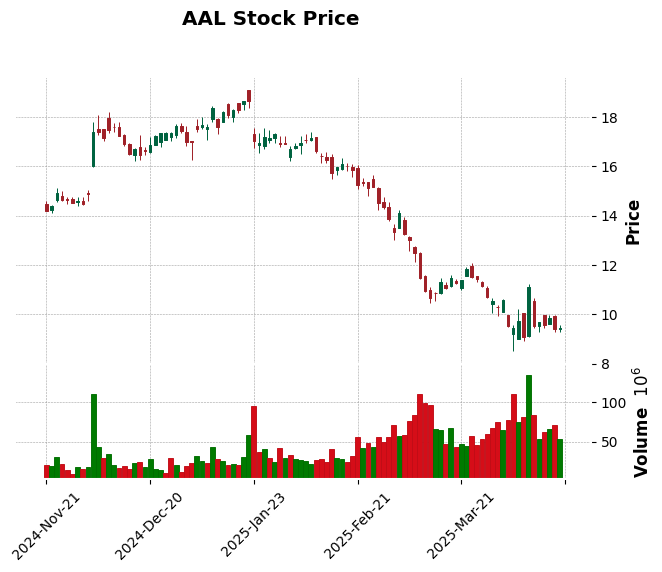

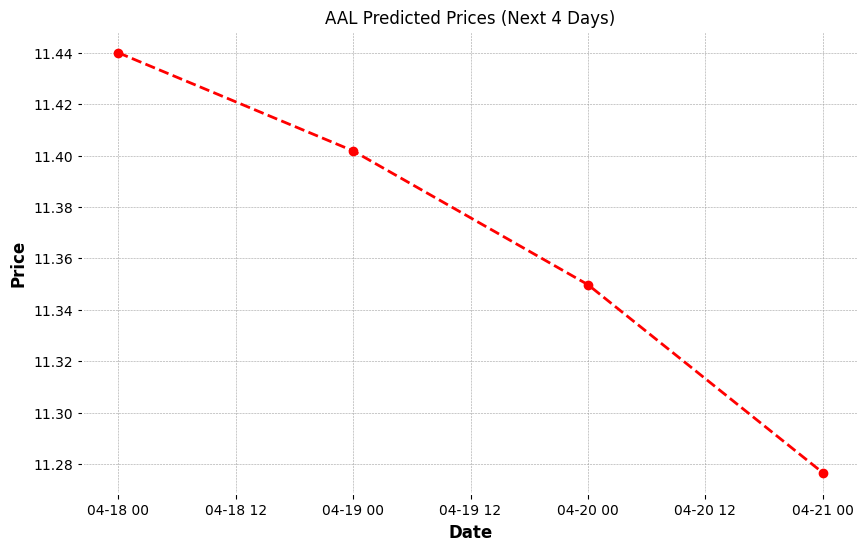

In [20]:
# Plotting the predictions
# Fetch full OHLCV data for charting
plot_data = yf.download(selected_ticker, period=f'{WINDOW_SIZE + 20}d', interval='1d')

# Flatten MultiIndex if any
if isinstance(plot_data.columns, pd.MultiIndex):
    plot_data.columns = [col[0] for col in plot_data.columns]

# Clean OHLCV types
required_ohlcv = ['Open', 'High', 'Low', 'Close', 'Volume']
missing_cols = [col for col in required_ohlcv if col not in plot_data.columns]
if missing_cols:
    raise KeyError(f"Missing columns in data: {missing_cols}")

plot_data[required_ohlcv] = plot_data[required_ohlcv].apply(pd.to_numeric, errors='coerce')
plot_data.dropna(subset=required_ohlcv, inplace=True)

# Confirm enough rows to plot
if len(plot_data) < WINDOW_SIZE:
    raise ValueError(f"Not enough rows to plot. Only {len(plot_data)} rows available.")

#Generate prediction dates
last_date = plot_data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

#Build predictions DataFrame
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

#Plot candlestick chart (last 100 days)
mpf.plot(plot_data[-WINDOW_SIZE:], type='candle', style='charles', volume=True, title=f"{selected_ticker} Stock Price")

#Overlay prediction points
plt.figure(figsize=(10, 6))
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')
plt.title(f"{selected_ticker} Predicted Prices (Next 4 Days)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


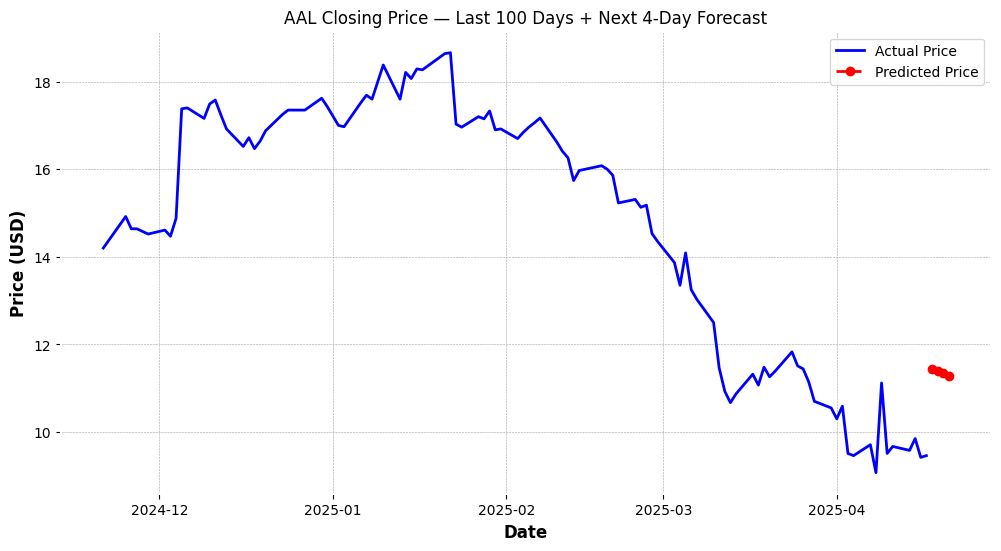

In [21]:

# Fetch recent stock data
forecast_data = yf.download(selected_ticker, period='150d', interval='1d')
close_series = forecast_data['Close'].squeeze()

# Add indicators
forecast_data['RSI'] = ta.momentum.RSIIndicator(close=close_series).rsi()
forecast_data['MACD'] = ta.trend.MACD(close=close_series).macd()
bb = ta.volatility.BollingerBands(close=close_series)
forecast_data['Bollinger_High'] = bb.bollinger_hband()
forecast_data['Bollinger_Low'] = bb.bollinger_lband()

# Drop NaNs from indicators
forecast_data.dropna(inplace=True)

# Check enough data available
if len(forecast_data) < WINDOW_SIZE:
    raise ValueError(f"Need at least {WINDOW_SIZE} rows for prediction. Got {len(forecast_data)}.")

# Extract the latest WINDOW_SIZE rows and scale
latest_data = forecast_data[required_columns].values[-WINDOW_SIZE:]
scaled_latest = scaler.transform(latest_data)
current_batch = scaled_latest.reshape(1, WINDOW_SIZE, FEATURE_COUNT)

# Predict next 4 days
predicted_prices = []
for _ in range(4):
    next_scaled = model.predict(current_batch)
    
    # Combine predicted close with dummy zeros for other features
    padded = np.concatenate([next_scaled, np.zeros((1, FEATURE_COUNT - 1))], axis=1)
    predicted_price = scaler.inverse_transform(padded)[0, 0]  # Only care about 'Close'
    predicted_prices.append(predicted_price)
    
    # Prepare input for next day
    next_input = np.concatenate([next_scaled, np.zeros((1, FEATURE_COUNT - 1))], axis=1)
    current_batch = np.append(current_batch[:, 1:, :], [next_input], axis=1)

# Create prediction date index
last_date = forecast_data.index[-1]
prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=4)
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Plot the actual and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(forecast_data.index[-WINDOW_SIZE:], forecast_data['Close'][-WINDOW_SIZE:], label="Actual Price", color='blue')
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='--', marker='o', color='red', label="Predicted Price")
plt.title(f"{selected_ticker} Closing Price — Last {WINDOW_SIZE} Days + Next 4-Day Forecast")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()
